In [48]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error





# Load the dataset
file_path = 'C:/Users/Mr Maziya/Downloads/spaza_shop_sales (1).csv'  # Adjust the path based on where the file is stored
spaza_sales_df = pd.read_csv(file_path)

# Display the first few rows to confirm it's loaded correctly
print(spaza_sales_df.head())


         date       sales   category   inventory day_of_week  promotion  \
0  2022-01-01  176.000000  Household   60.400000    Saturday          1   
1  2022-01-02  126.911859     Drinks   96.308814      Sunday          0   
2  2022-01-03  102.809214     Drinks  135.719079      Monday          0   
3  2022-01-04  107.677859       Food  115.232214     Tuesday          1   
4  2022-01-05  106.504171  Household  109.349583   Wednesday          0   

  store_location weather  discount_percentage  customer_foot_traffic  
0          Urban  Cloudy                   10                    147  
1          Rural   Sunny                   10                     83  
2          Rural   Rainy                    0                    129  
3          Rural   Sunny                    5                     57  
4          Rural  Cloudy                   20                    129  


In [49]:
missing_values = spaza_sales_df.isnull().sum()
print(missing_values)

spaza_sales_df.fillna(method='ffill', inplace=True)
spaza_sales_df['sales'].fillna(spaza_sales_df['sales'].mean(), inplace=True)


date                     0
sales                    0
category                 0
inventory                0
day_of_week              0
promotion                0
store_location           0
weather                  0
discount_percentage      0
customer_foot_traffic    0
dtype: int64


C:\Users\Mr Maziya\AppData\Local\Temp\ipykernel_10688\144446047.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spaza_sales_df.fillna(method='ffill', inplace=True)
C:\Users\Mr Maziya\AppData\Local\Temp\ipykernel_10688\144446047.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spaza_sales_df['sales'].fillna(spaza_sales_df['sales'].mean(), inplace=True)


In [50]:
spaza_sales_df['sales'].plot(kind='box')
plt.show()

Q1 = spaza_sales_df['sales'].quantile(0.25)
Q3 = spaza_sales_df['sales'].quantile(0.75)
IQR = Q3 - Q1
spaza_sales_df = spaza_sales_df[~((spaza_sales_df['sales'] < (Q1 - 1.5 * IQR)) | (spaza_sales_df['sales'] > (Q3 + 1.5 * IQR)))]



In [51]:
spaza_sales_df['date'] = pd.to_datetime(spaza_sales_df['date'])
spaza_sales_df.set_index('date', inplace=True)


In [52]:
spaza_sales_df['sales'].plot(figsize=(10,6))
plt.show()


In [53]:
decomposition = seasonal_decompose(spaza_sales_df['sales'], model='additive', period=7)
decomposition.plot()
plt.show()


In [54]:
spaza_sales_df['rolling_sales'] = spaza_sales_df['sales'].rolling(window=7).mean()



In [55]:
spaza_sales_df['lag_1'] = spaza_sales_df['sales'].shift(1)


In [56]:
spaza_sales_df.reset_index(inplace=True)


In [57]:
prophet_df = spaza_sales_df[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})


In [58]:

# Prepare data for Prophet
prophet_df = spaza_sales_df[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})


In [59]:
m = Prophet()

# Add weekly seasonality (Prophet already accounts for this, but it can be customized)
m.add_seasonality(name='weekly', period=7, fourier_order=3)

# Fit the model
m.fit(prophet_df)


13:57:21 - cmdstanpy - INFO - Chain [1] start processing
13:57:21 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
holidays = pd.DataFrame({
    'holiday': 'public_holiday',
    'ds': pd.to_datetime(['2024-01-01', '2024-03-21', '2024-04-27', '2024-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

# Add holidays to the model
m = Prophet(holidays=holidays)
m.add_seasonality(name='weekly', period=7, fourier_order=3)

# Fit the model with holidays
m.fit(prophet_df)


13:57:26 - cmdstanpy - INFO - Chain [1] start processing
13:57:26 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
# Create future dates (e.g., next 90 days)
future = m.make_future_dataframe(periods=90)

# Forecast
forecast = m.predict(future)

# Display the forecasted data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds        yhat  yhat_lower  yhat_upper
815 2024-03-26  265.641311  255.262574  275.610369
816 2024-03-27  268.416023  258.209332  279.054667
817 2024-03-28  266.658997  256.155419  276.947067
818 2024-03-29  267.737005  257.342960  279.201875
819 2024-03-30  286.967510  276.630215  297.818057

C:\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcs

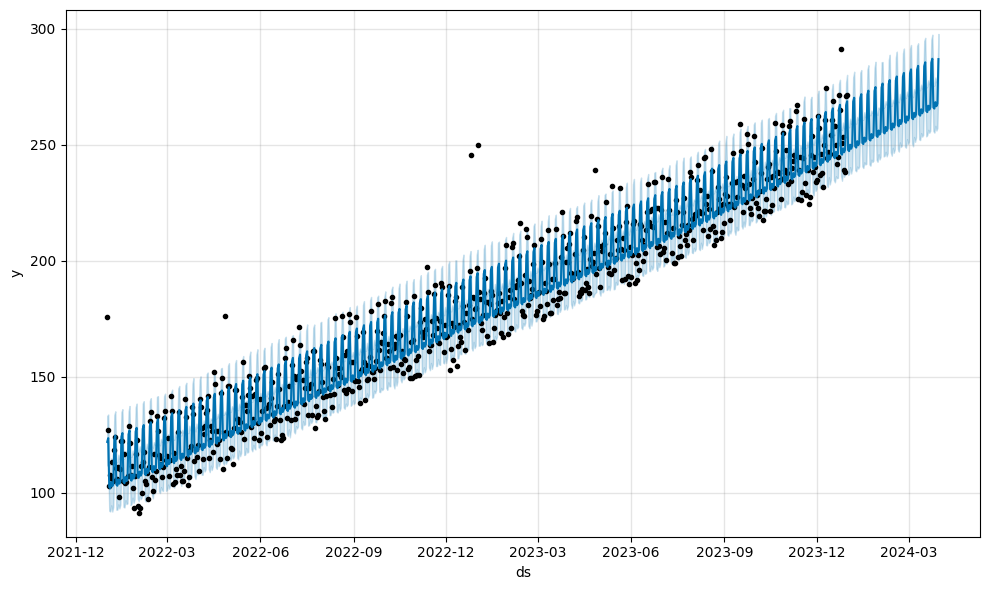

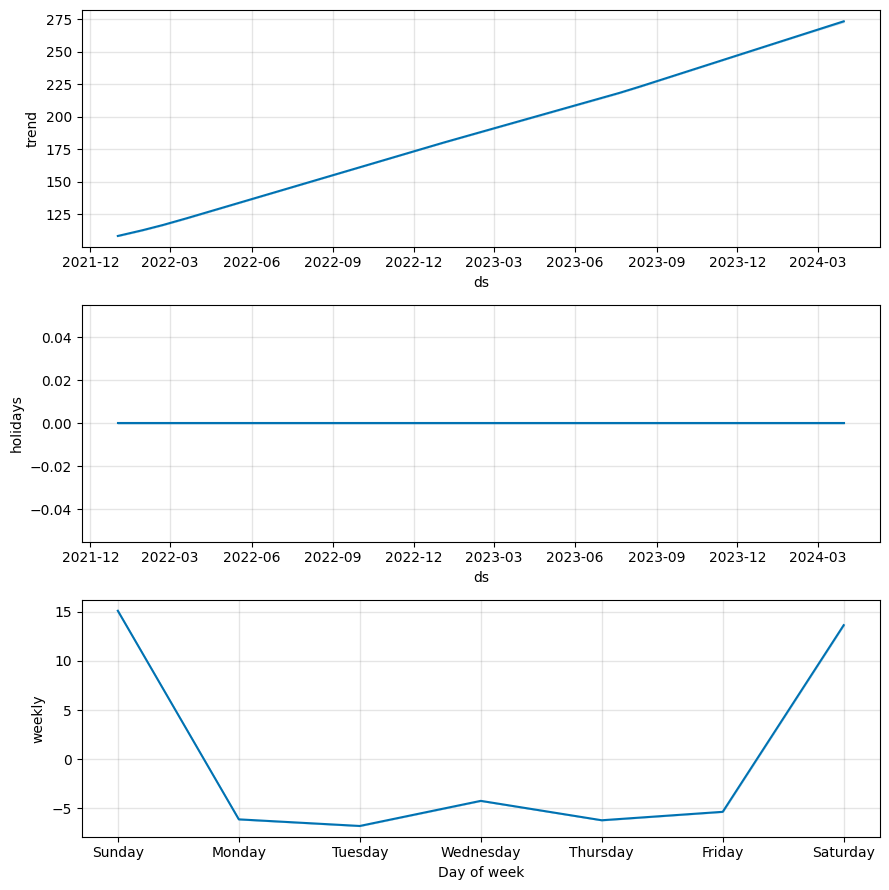

In [62]:
# Plot the forecasted values
fig = m.plot(forecast)

# Plot the components (trend, weekly seasonality, holiday effects)
fig_components = m.plot_components(forecast)


In [63]:

# Perform ADF test on the sales data
result = adfuller(spaza_sales_df['sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: 0.02752441551501691
p-value: 0.960750001625938


In [35]:
# Apply differencing to make the data stationary
spaza_sales_df['sales_diff'] = spaza_sales_df['sales'].diff().dropna()


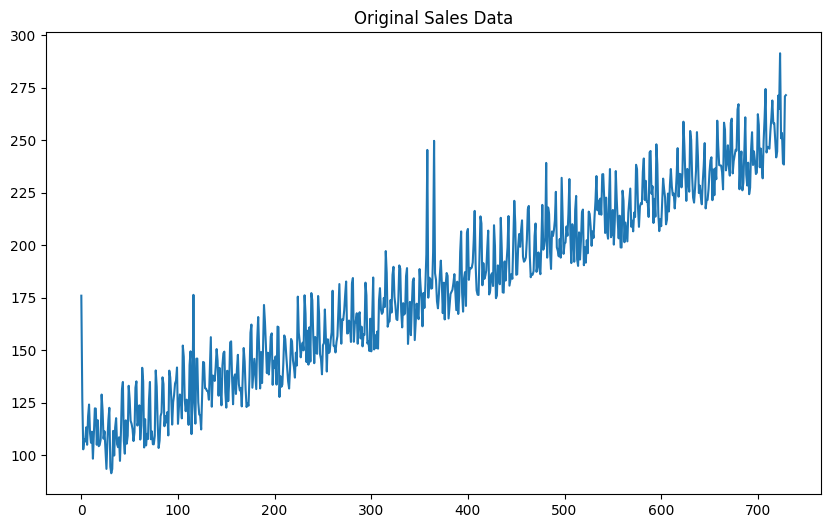

In [36]:

# Plot original sales data
spaza_sales_df['sales'].plot(figsize=(10, 6))
plt.title('Original Sales Data')
plt.show()

# Plot differenced data
spaza_sales_df['sales_diff'].plot(figsize=(10, 6))
plt.title('Differenced Sales Data')
plt.show()


In [37]:
# Plot ACF and PACF
plot_acf(spaza_sales_df['sales_diff'].dropna())
plt.show()

plot_pacf(spaza_sales_df['sales_diff'].dropna())
plt.show()


In [39]:
# Define p, d, q (example values, adjust based on ACF and PACF analysis)
p = 1  # autoregressive part
d = 1  # differencing part
q = 1  # moving average part

# Fit the ARIMA model
model = ARIMA(spaza_sales_df['sales'], order=(p, d, q))

# Fit the model
arima_result = model.fit()

# Summary of the model
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  730
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2866.566
Date:                Fri, 13 Sep 2024   AIC                           5739.132
Time:                        22:17:46   BIC                           5752.907
Sample:                             0   HQIC                          5744.447
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2664      0.042      6.338      0.000       0.184       0.349
ma.L1         -0.9172      0.020    -45.541      0.000      -0.957      -0.878
sigma2       152.1187      6.151     24.732      0.0

In [40]:
# Forecast the next 90 days
forecast = arima_result.get_forecast(steps=90)

# Get confidence intervals for the forecast
forecast_df = forecast.conf_int()

# Plot the forecasted values
forecast_df['mean'] = forecast.predicted_mean
forecast_df[['mean', 'lower sales', 'upper sales']].plot()
plt.title('ARIMA Forecast')
plt.show()


In [41]:
# Actual vs Predicted
actual = spaza_sales_df['sales'][-90:]  # Last 90 days of actual sales
predicted = forecast.predicted_mean

# RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse}')


RMSE: 19.127799528155773


In [42]:

# Select the relevant column (sales) and reshape
data = spaza_sales_df['sales'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences and labels (X, y)
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Set sequence length (e.g., last 7 days)
sequence_length = 7
X, y = create_sequences(data_scaled, sequence_length)

# Train-test split (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [43]:

# Build LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(units=1))  # Predicting a single value (sales)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0901 - val_loss: 0.0520
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0139 - val_loss: 0.0080
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0037

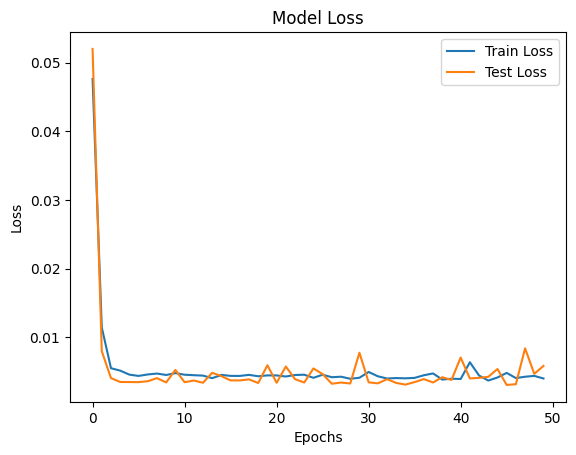

In [44]:
# Plot the loss


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


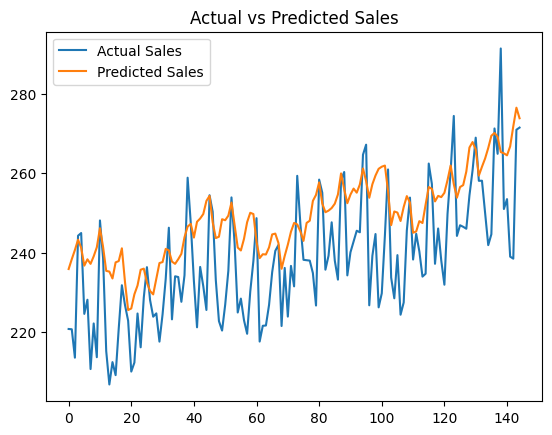

In [45]:
# Predict on the test data
y_pred = model.predict(X_test)

# Inverse the scaling to get original sales values
y_pred_scaled = scaler.inverse_transform(y_pred)
y_test_scaled = scaler.inverse_transform(y_test)

# Plot actual vs predicted sales
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(y_pred_scaled, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()


In [46]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 15.275479551189681
MAE: 12.705685358512216
